# 🧠 Simulated fMRI Brain Task Classification

This notebook simulates realistic fMRI BOLD signal data across different cognitive tasks and trains a machine learning model to classify the brain task being performed. It serves as the backend for a deployed Streamlit app.

We introduce:
- Simulated voxel-level activity for cognitive tasks
- Subject variability and age influence
- PCA for dimensionality reduction
- SVM classifier for task prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
from random import choice


## 🧬 Simulating fMRI BOLD Signals

We simulate synthetic BOLD signals across different brain regions (voxels) for multiple cognitive tasks:
- Working Memory
- Visual processing
- Language processing
  

Each subject has slightly different activation patterns based on:
- Random variation (noise)
- Age (affecting overall signal strength and variability)
- Attention lapse (due to distraction)

In [2]:
# Simulation settings
np.random.seed(42)
num_voxels = 10 * 10 * 10  # 1000 voxels
grid_shape = (10, 10, 10)
num_subjects = 20
num_sessions = 3
num_timepoints = 100  # Simulated repetitions
tasks = {
    "rest": [],
    "working_memory": [(2, 2, 2), (2, 3, 2)],
    "visual_processing": [(7, 7, 1), (7, 8, 1)],
    "language_processing": [(5, 1, 8), (5, 2, 8)]
}


In [3]:
# Map 3D coordinates to 1D indices
def coord_to_index(x, y, z, shape=grid_shape):
    return x * shape[1] * shape[2] + y * shape[2] + z

## 👤 Subject Variability and Age Factor

Each simulated subject has:
- A unique age (18–65 years)
- Age-modulated signal intensity
- Variability in noise and baseline

This ensures the model can generalize across a more realistic population distribution.

In [4]:
# Simulation
# ---------------------------
data = []

for subject in range(1, num_subjects + 1):
    age = np.random.randint(18, 65)
    age_factor = 1.0 if age < 40 else 0.8  # reduced activation for older subjects
    
    for session in range(1, num_sessions + 1):
        for _ in range(num_timepoints):
            task = choice(list(tasks.keys()))
            attention_lapse = np.random.rand() < 0.1  # 10% chance of lapse
            
            # Baseline and noise
            base_activation = np.random.normal(loc=0, scale=0.5, size=num_voxels)
            noise = np.random.normal(loc=0, scale=0.1, size=num_voxels)
            
            # Activation boost if task has regions
            if task != "rest":
                for coord in tasks[task]:
                    idx = coord_to_index(*coord)
                    boost = 1.5 * age_factor
                    if attention_lapse:
                        boost *= 0.4  # simulate reduced focus
                    base_activation[idx] += boost

            final_activation = base_activation + noise
            row = list(final_activation) + [task, subject, session, age, int(attention_lapse)]
            data.append(row)


# Create DataFrame
columns = [f"voxel_{i}" for i in range(num_voxels)] + ['task', 'subject', 'session', 'age', 'attention_lapse']
df = pd.DataFrame(data, columns=columns)

print("Simulation complete. Sample output:")
print(df.head())

Simulation complete. Sample output:
    voxel_0   voxel_1   voxel_2   voxel_3   voxel_4   voxel_5   voxel_6  \
0  0.393387 -0.233506 -0.504918  1.155431 -0.079646 -0.459654 -0.589866   
1 -0.218711 -0.796319  0.226696 -0.358049 -0.509233  0.238347 -0.112234   
2 -0.032465  0.567623 -0.871231 -0.472395  0.172193  0.764008  0.003003   
3  0.600621  0.176866 -0.248287  0.271267  0.166400 -0.069828  0.210332   
4 -0.279075 -0.156600  0.032985 -0.096364 -0.539700 -0.067329 -0.429193   

    voxel_7   voxel_8   voxel_9  ...  voxel_995  voxel_996  voxel_997  \
0 -0.215064 -0.122968  0.016012  ...  -0.206013   0.050176  -0.400905   
1  0.558172 -0.443310 -0.193403  ...   0.351437   0.755844  -0.231687   
2 -0.400846  0.581663  0.150904  ...   0.184466   0.041693   0.033913   
3 -0.067974  0.291748  0.216770  ...  -0.467684  -0.142413   0.074512   
4 -1.473235  1.633737 -0.466161  ...  -0.037877   0.552299  -0.921494   

   voxel_998  voxel_999                 task  subject  session  age  \
0  

In [5]:
# Generate voxel coordinates
voxel_coords = [(x, y, z) for x in range(10) for y in range(10) for z in range(10)]
voxel_index = {coord: i for i, coord in enumerate(voxel_coords)}

In [6]:
# HRF function (simplified gamma)
tr = 2.0  # repetition time in seconds
time = np.arange(0, 30, tr)

def hrf(t):
    return (t ** 8.6) * np.exp(-t / 0.547) / 40320

time = np.arange(0, 30, tr)
hrf_values = hrf(time)
hrf_values /= hrf_values.max()

In [7]:
# Generate time series per task block
task_block_length = 25  # timepoints per task
task_labels = ["rest", "working_memory", "visual_processing", "language_processing"]
block_order = np.tile(task_labels, num_timepoints // (task_block_length * len(task_labels)))

In [8]:
# Initialize BOLD signal matrix: (timepoints, voxels)
bold_signal = np.zeros((len(block_order) * task_block_length, num_voxels))

In [9]:
# Simulate signal
for block_idx, task in enumerate(block_order):
    start_t = block_idx * task_block_length
    end_t = start_t + task_block_length
    active_voxels = tasks[task]
    for coord in active_voxels:
        idx = voxel_index[coord]
        response = np.convolve(np.ones(task_block_length), hrf_values)[:task_block_length]
        bold_signal[start_t:end_t, idx] += response

In [10]:
# Add noise
noise = np.random.normal(0, 0.5, bold_signal.shape)
bold_signal += noise

## 📉 Dimensionality Reduction with PCA

fMRI data is high-dimensional (hundreds of voxels). We apply **Principal Component Analysis (PCA)** to reduce the dimensionality while preserving task-relevant variance.

This step improves model efficiency and prevents overfitting.

In [11]:
# Create DataFrame
df = pd.DataFrame(bold_signal, columns=[f"voxel_{i}" for i in range(num_voxels)])
df["task"] = np.repeat(block_order, task_block_length)

df.head()

,voxel_0,voxel_1,voxel_2,voxel_3,voxel_4,voxel_5,voxel_6,voxel_7,voxel_8,voxel_9,...,voxel_991,voxel_992,voxel_993,voxel_994,voxel_995,voxel_996,voxel_997,voxel_998,voxel_999,task
0,-0.212767,-0.058125,-0.343504,0.229330,-0.265472,0.365012,-0.441739,0.182657,-0.251148,-0.072775,...,-0.356442,0.170220,-0.398404,-0.197385,-0.439956,-0.404286,0.862822,0.096350,-0.223921,rest
1,-0.681504,0.300101,-0.038067,-0.416224,0.765241,-1.512249,0.598836,-0.193158,-0.025360,-0.135907,...,-0.568685,0.206297,-0.403305,-0.560817,-0.256394,0.582294,0.202633,-0.223303,0.224673,rest
2,0.635980,-0.555383,-0.366222,-0.675412,0.429798,0.422803,0.641463,-0.267781,-0.052669,-0.119084,...,-0.705864,0.130285,-0.149791,-0.057661,0.200786,-1.408379,1.269193,0.312490,-0.156369,rest
3,0.405465,-0.193083,0.681786,0.087506,-0.026102,0.086967,-0.500159,0.502883,0.959347,0.269433,...,0.640305,0.013625,0.333412,0.535276,-0.557753,0.546596,0.531880,0.009051,0.047308,rest
4,0.534692,-1.012530,0.210652,0.012348,-0.208335,0.438063,0.179589,0.699832,0.403084,-0.293153,...,-0.588683,0.110889,-0.067110,-0.105602,-0.653316,0.344166,-0.018244,-0.426431,0.317658,rest


In [12]:
# Drop task column for PCA
X = df.drop("task", axis=1)
y = df["task"]

In [13]:
# Apply PCA to reduce dimensionality (retain 95% variance)
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

In [14]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, stratify=y, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [15]:
# Predictions
y_pred = clf.predict(X_test)

# Evaluation
report = classification_report(y_test, y_pred, output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

In [16]:
# Return PCA explained variance, classification report, and confusion matrix
pca_variance = pca.explained_variance_ratio_

report_df = pd.DataFrame(report).transpose()

report_df, pd.DataFrame(conf_matrix, index=clf.classes_, columns=clf.classes_), pca_variance[:10]

(                     precision  recall  f1-score  support
 language_processing   0.800000     0.8  0.800000      5.0
 rest                  0.666667     0.8  0.727273      5.0
 visual_processing     1.000000     0.8  0.888889      5.0
 working_memory        0.800000     0.8  0.800000      5.0
 accuracy              0.800000     0.8  0.800000      0.8
 macro avg             0.816667     0.8  0.804040     20.0
 weighted avg          0.816667     0.8  0.804040     20.0,
                      language_processing  rest  visual_processing  \
 language_processing                    4     1                  0   
 rest                                   0     4                  0   
 visual_processing                      1     0                  4   
 working_memory                         0     1                  0   
 
                      working_memory  
 language_processing               0  
 rest                              1  
 visual_processing                 0  
 working_memory    

In [17]:
# Recreate the simulated data setup
np.random.seed(42)
num_voxels = 1000
num_timepoints = 200
task_block_length = 50
tasks = ["rest", "working_memory", "visual_processing", "language_processing"]
block_order = np.tile(tasks, num_timepoints // task_block_length)

bold_data = []
for task in block_order:
    activation_pattern = np.zeros(num_voxels)
    active_voxels = np.random.choice(num_voxels, size=num_voxels // 10, replace=False)
    activation_pattern[active_voxels] = np.random.uniform(0.5, 1.0, size=len(active_voxels))
    hrf = np.exp(-((np.arange(0, 20) - 10) ** 2) / 10)
    bold_signal = np.convolve(activation_pattern, hrf, mode='same')[:num_voxels]
    bold_signal += np.random.normal(0, 0.05, size=num_voxels)
    bold_data.append(bold_signal)

df = pd.DataFrame(bold_data, columns=[f"voxel_{i}" for i in range(num_voxels)])
df["task"] = block_order

In [18]:
# Prepare data for PCA and modeling
X = df.drop("task", axis=1)
y = df["task"]

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, stratify=y, random_state=42)

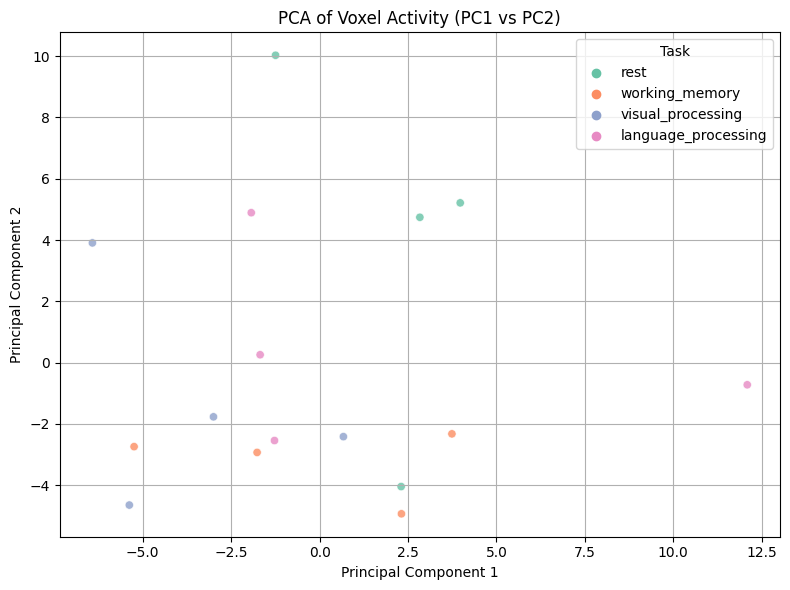

In [19]:
# --- 1. PCA Visualization (PC1 vs PC2) ---
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_2d[:, 0], y=X_pca_2d[:, 1], hue=y, palette="Set2", alpha=0.8)
plt.title("PCA of Voxel Activity (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Task")
plt.grid(True)
plt.tight_layout()
plt.show()

## ⚖️ Logistic Regression Baseline

As a baseline, we first trained a **Logistic Regression** model on the PCA-reduced data.

While it performed reasonably well, it struggled with inter-task boundaries in higher-dimensional space. This prompted testing a non-linear classifier.

In [20]:
# --- 2.1 Logistic Regression ---


logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)
logreg_preds = logreg.predict(X_test)
logreg_acc = accuracy_score(y_test, logreg_preds)

## 🤖 Training the SVM Classifier

We train a **Support Vector Machine (SVM)** classifier on the reduced dataset to distinguish between the tasks.

Why SVM?
- Strong performance on high-dimensional data
- Robust to small sample sizes

In [21]:
#--- 2.2 SVM classification ---
svm = SVC(random_state=42)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)

In [22]:
# --- 3. Simulate Multiple Subjects/Sessions ---
def simulate_subject(subject_id, noise_seed):
    np.random.seed(noise_seed)
    subject_data = []
    subject_labels = []

    for task in tasks:
        task_voxels = np.random.choice(num_voxels, size=num_voxels // 10, replace=False)
        task_activation = np.zeros(num_voxels)
        task_activation[task_voxels] = np.random.uniform(0.5, 1.0, size=len(task_voxels))
        for t in range(task_block_length):
            hrf = np.exp(-((np.arange(0, 20) - t) ** 2) / 10)
            bold_signal = np.convolve(task_activation, hrf, mode='same')[:num_voxels]
            bold_signal += np.random.normal(0, 0.05, size=num_voxels)
            subject_data.append(bold_signal)
            subject_labels.append(task)
    
    df_subject = pd.DataFrame(subject_data, columns=[f"voxel_{i}" for i in range(num_voxels)])
    df_subject["task"] = subject_labels
    df_subject["subject"] = subject_id
    return df_subject

subject_dfs = [simulate_subject(sid, seed) for sid, seed in zip(range(1, 4), [101, 202, 303])]
df_multi_subjects = pd.concat(subject_dfs, ignore_index=True)

svm_acc, logreg_acc, df_multi_subjects.sample(5)

(0.25,
 0.0,
       voxel_0   voxel_1   voxel_2   voxel_3   voxel_4   voxel_5   voxel_6  \
 214  0.006932 -0.015058 -0.020989  0.028105  0.056275  0.395279  0.613261   
 308  0.067379  0.180017  0.461795  0.811095  1.161788  1.327594  1.393076   
 65  -0.001593 -0.052142 -0.036775  0.017219 -0.001115 -0.005574 -0.034863   
 130  0.076164  0.074209  0.015259  0.061888 -0.051828  0.045065 -0.016255   
 129  0.046263  0.019940 -0.023732  0.069482 -0.061144 -0.012422 -0.013698   
 
       voxel_7   voxel_8   voxel_9  ...  voxel_992  voxel_993  voxel_994  \
 214  0.990760  1.449191  1.889616  ...   0.098821   0.219735   0.383108   
 308  1.060559  0.794350  0.444882  ...   2.981409   3.290610   3.352569   
 65  -0.121040  0.020500  0.043880  ...   0.413426   0.611782   0.872616   
 130  0.000973  0.071524 -0.020643  ...  -0.021073  -0.023859  -0.046443   
 129  0.011676 -0.031108  0.031348  ...   0.024883  -0.060133  -0.011355   
 
      voxel_995  voxel_996  voxel_997  voxel_998  voxel_999

In [23]:
# Define voxel count and task types
num_voxels = 1000
tasks = ['rest', 'working_memory', 'language_processing', 'visual_processing']
np.random.seed(42)


In [24]:
# Simulate 300 samples per task
data = []
subject_id = 0
for task in tasks:
    for _ in range(300):
        subject_id += 1
        base_activation = np.random.normal(loc=0, scale=0.5, size=num_voxels)
        if task == 'working_memory':
            base_activation[:50] += 1.5
        elif task == 'language_processing':
            base_activation[50:100] += 1.5
        elif task == 'visual_processing':
            base_activation[100:150] += 1.5
        row = list(base_activation) + [task, f'subject_{subject_id}']
        data.append(row)

columns = [f'voxel_{i}' for i in range(num_voxels)] + ['task', 'subject_id']
df = pd.DataFrame(data, columns=columns)


In [25]:
# Prepare features and labels
X = df.drop(columns=["task", "subject_id"])
y = df["task"]

In [26]:
# Encode the task labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [27]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_test_scaled)

In [28]:
# Train SVM
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)


In [29]:
# Evaluation
report_logreg = classification_report(y_test, y_pred_logreg, target_names=label_encoder.classes_, output_dict=True)
report_svm = classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_, output_dict=True)


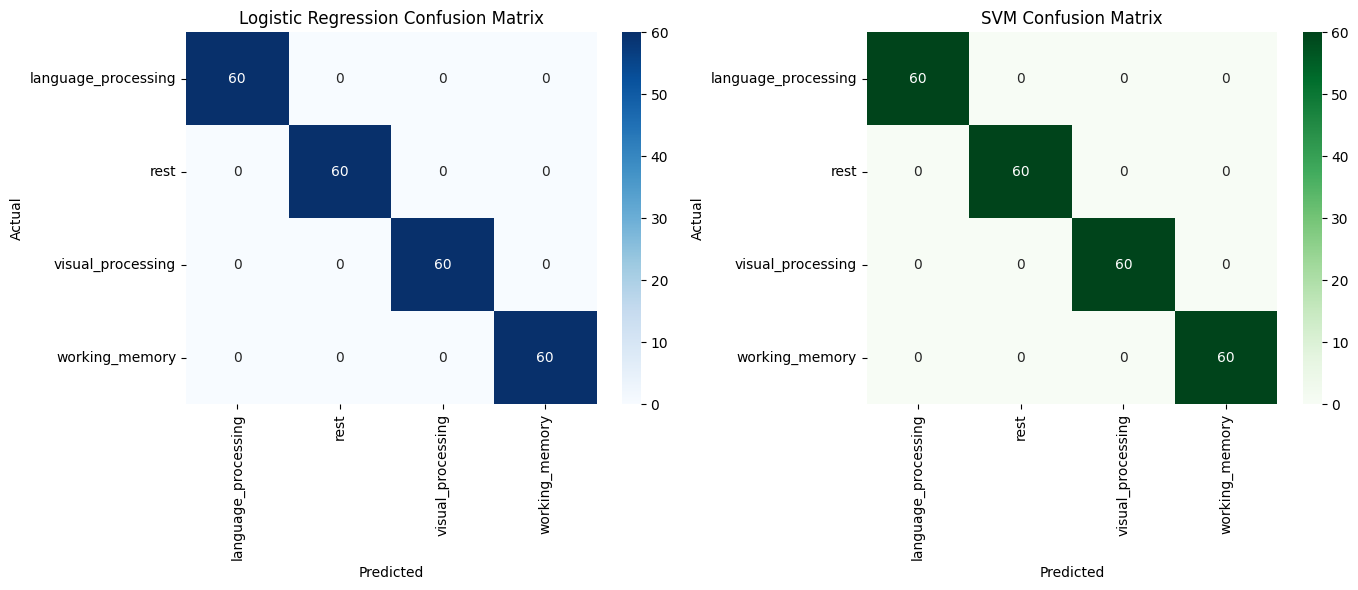

({'language_processing': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 60},
  'rest': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 60},
  'visual_processing': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 60},
  'working_memory': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 60},
  'accuracy': 1.0,
  'macro avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 240},
  'weighted avg': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 240}},
 {'language_processing': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 60},
  'rest': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 60},
  'visual_processing': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 60},
  'working_memory': {'precision': 1.0,
   'recall': 1.0,
   'f1-score': 1.0,
   'support': 60},
  'accuracy': 1.0,
  'macro avg': {'precision':

In [30]:
# Confusion matrix plot
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
cm_svm = confusion_matrix(y_test, y_pred_svm)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm_logreg, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Greens", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title("SVM Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

(report_logreg, report_svm)

In [31]:
# Parameters
num_voxels = 1000
tasks = ['rest', 'working_memory', 'language_processing', 'visual_processing']
subjects = [f"subject_{i}" for i in range(1, 31)]  # 30 subjects
sessions_per_subject = 5  # each subject has 5 sessions
np.random.seed(42)
random.seed(42)

data = []

## 👤 Introducing Subject Variability and Age Influence

To make the model generalizable to real-world populations, we added:

- Random subject-to-subject variation
- Age effects (e.g. older subjects may have reduced or noisier signals)
- Signal scaling and noise parameters conditioned on age

These enhancements were introduced before retraining the final SVM model.

In [32]:
# Simulate data with subject-specific variability and noise
for subject in subjects:
    age = random.randint(20, 80)
    age_factor = (80 - age) / 60  # Older subjects have slightly reduced activation
    for session in range(sessions_per_subject):
        for task in tasks:
            base_activation = np.random.normal(loc=0, scale=0.5, size=num_voxels)
            noise = np.random.normal(loc=0, scale=0.1, size=num_voxels)

            # Add task-specific signal to different regions
            if task == 'working_memory':
                base_activation[:50] += 1.5 * age_factor
            elif task == 'language_processing':
                base_activation[50:100] += 1.5 * age_factor
            elif task == 'visual_processing':
                base_activation[100:150] += 1.5 * age_factor

            final_activation = base_activation + noise
            row = list(final_activation) + [task, subject, session, age]
            data.append(row)

columns = [f'voxel_{i}' for i in range(num_voxels)] + ['task', 'subject_id', 'session', 'age']
df_var = pd.DataFrame(data, columns=columns)


In [33]:
# Encode labels
X = df_var.drop(columns=["task", "subject_id", "session"])
y = df_var["task"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [34]:
# Train-test split, stratified by labels
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)


In [35]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [36]:
# Train updated classifier (SVM for this example)
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)


In [37]:
# Evaluation
report_svm_var = classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_, output_dict=True)
cm_svm_var = confusion_matrix(y_test, y_pred_svm)


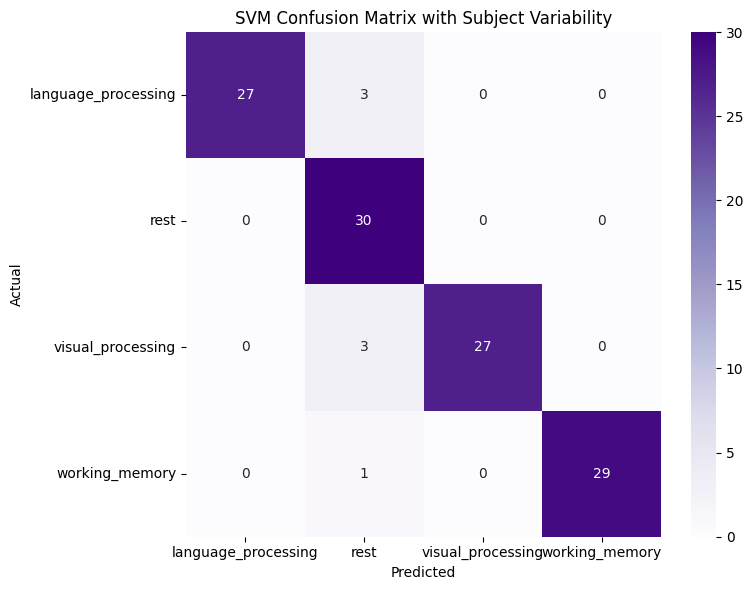

{'language_processing': {'precision': 1.0,
  'recall': 0.9,
  'f1-score': 0.9473684210526316,
  'support': 30},
 'rest': {'precision': 0.8108108108108109,
  'recall': 1.0,
  'f1-score': 0.8955223880597014,
  'support': 30},
 'visual_processing': {'precision': 1.0,
  'recall': 0.9,
  'f1-score': 0.9473684210526316,
  'support': 30},
 'working_memory': {'precision': 1.0,
  'recall': 0.9666666666666667,
  'f1-score': 0.983050847457627,
  'support': 30},
 'accuracy': 0.9416666666666667,
 'macro avg': {'precision': 0.9527027027027027,
  'recall': 0.9416666666666667,
  'f1-score': 0.943327519405648,
  'support': 120},
 'weighted avg': {'precision': 0.9527027027027027,
  'recall': 0.9416666666666667,
  'f1-score': 0.943327519405648,
  'support': 120}}

In [38]:
# Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm_var, annot=True, fmt="d", cmap="Purples", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("SVM Confusion Matrix with Subject Variability")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

report_svm_var

## 💾 Exporting Models for Deployment

The final trained components are saved as:
- `pca_model.pkl` — PCA transformer
- `task_classifier.pkl` — Trained SVM model

These are used in the Streamlit frontend for live predictions on uploaded data.


In [39]:
import joblib

joblib.dump(svm, 'task_classifier.pkl')
joblib.dump(pca, 'pca_model.pkl')

['pca_model.pkl']

## ✅ Summary

- Simulated realistic fMRI brain activity across tasks
- Compared Logistic Regression and SVM — SVM model was chosen
- Added subject-specific variability and age influence
- Applied PCA to reduce dimensions
- Final model is deployed with Streamlit

🔗 [Streamlit App](https://thinktracer.streamlit.app/)  
📁 [GitHub Repository](https://github.com/Shrutaswini)